In [1]:
!nvidia-smi

Mon Mar 21 22:52:27 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 462.30       Driver Version: 462.30       CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  GeForce GTX 1650   WDDM  | 00000000:01:00.0  On |                  N/A |
| N/A   40C    P8     1W /  N/A |    406MiB /  4096MiB |      1%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
# Imports

# Imports para manipulação e visualização de dados
import numpy as np
import pandas as pd
import matplotlib as m
import matplotlib.pyplot as plt
import seaborn as sns
import pandas_profiling
from pandas_profiling import ProfileReport

# Imports para pré-processamento e avaliação
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score

# Imports para Deep Learning
import tensorflow
import keras
from keras.models import Sequential
from keras.layers import Dense, Input, Dropout
from keras.losses import categorical_crossentropy
from tensorflow.keras.utils import to_categorical
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

# Imports para formatação dos gráficos
from matplotlib.pylab import rcParams 
rcParams['axes.labelsize'] = 14
rcParams['xtick.labelsize'] = 12
rcParams['ytick.labelsize'] = 12
rcParams['text.color'] = 'k'
rcParams['figure.max_open_warning'] = 30
rcParams['figure.figsize'] = 10,8
m.style.use('ggplot')
%matplotlib inline

In [3]:
# Versões dos pacotes usados neste jupyter notebook
%reload_ext watermark
%watermark -a "Rodrigo Abreu" --iversions

Author: Rodrigo Abreu

numpy           : 1.19.5
matplotlib      : 3.5.1
pandas_profiling: 3.1.0
tensorflow      : 2.6.0
sklearn         : 0.0
seaborn         : 0.11.2
keras           : 2.6.0
pandas          : 1.4.1



In [4]:
# Lista todos os dispositivos disponiveis
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 16502769916027676124
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 2258055988
locality {
  bus_id: 1
  links {
  }
}
incarnation: 12946317405288826744
physical_device_desc: "device: 0, name: GeForce GTX 1650, pci bus id: 0000:01:00.0, compute capability: 7.5"
]


In [5]:
import tensorflow as tf
print("Número Disponível de GPUs: ", len(tf.config.experimental.list_physical_devices('GPU')))

Número Disponível de GPUs:  1


In [6]:
# Lista o código de cada GPU
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## Carregando os Dados

In [7]:
# Carrega o dataset
dataset = pd.read_csv("dados/hotel_bookings.csv")

In [8]:
# Shape
dataset.shape

(119390, 32)

In [9]:
# Visualiza os dados
dataset.head(5)

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,...,No Deposit,NaN,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,...,No Deposit,304.0,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,...,No Deposit,240.0,NaN,0,Transient,98.0,0,1,Check-Out,2015-07-03


## Análise Exploratória

O Pandas Profiling gera um relatório completo de análise exploratória dos dados. Começamos por ele.

In [ ]:
# Gera relatório de análise exploratória
# prof = ProfileReport(dataset)

In [ ]:
# Visualiza o relatório
# prof

In [ ]:
# Salva o relatório em formato HTML
# prof.to_file(output_file = 'relatorio.html')

In [11]:
# Número de colunas
print(len(dataset.columns))

32


In [12]:
# Tipos de dados
dataset.dtypes

hotel                              object
is_canceled                         int64
lead_time                           int64
arrival_date_year                   int64
arrival_date_month                 object
arrival_date_week_number            int64
arrival_date_day_of_month           int64
stays_in_weekend_nights             int64
stays_in_week_nights                int64
adults                              int64
children                          float64
babies                              int64
meal                               object
country                            object
market_segment                     object
distribution_channel               object
is_repeated_guest                   int64
previous_cancellations              int64
previous_bookings_not_canceled      int64
reserved_room_type                 object
assigned_room_type                 object
booking_changes                     int64
deposit_type                       object
agent                             

In [13]:
# Vamos checar quais colunas são do tipo string
for column, series in dataset.items():
    if str(type(series[0])) == "<class 'str'>":
        print(column)

hotel
arrival_date_month
meal
country
market_segment
distribution_channel
reserved_room_type
assigned_room_type
deposit_type
customer_type
reservation_status
reservation_status_date


Não podemos levar valores no formato de texto para o treinamento do modelo. Vamos tratar isso daqui a pouco. Primeiro vamos checar se temos valores ausentes.

In [14]:
# Total de valores ausentes por coluna
dataset.isnull().sum()

hotel                                  0
is_canceled                            0
lead_time                              0
arrival_date_year                      0
arrival_date_month                     0
arrival_date_week_number               0
arrival_date_day_of_month              0
stays_in_weekend_nights                0
stays_in_week_nights                   0
adults                                 0
children                               4
babies                                 0
meal                                   0
country                              488
market_segment                         0
distribution_channel                   0
is_repeated_guest                      0
previous_cancellations                 0
previous_bookings_not_canceled         0
reserved_room_type                     0
assigned_room_type                     0
booking_changes                        0
deposit_type                           0
agent                              16340
company         

Sim, temos em algumas colunas. Então vamos ao processo de limpeza e transformação dos dados.

## Limpeza e Transformação

A coluna company tem quase todos os registros nulos e não faz sentido manter essa coluna. Vamos removê-la.

In [15]:
# Remove a coluna "company"
dataset = dataset.drop(['company'], axis = 1)

Temos ainda duas colunas com valores nulos e diversas estratégias poderiam ser adotadas. Valores ausentes não podem ser deixados no dataset.

Para os valores ausentes na coluna "country", vamos apenas remover a coluna. Para a coluna "agent", removeremos todas as linhas onde esta coluna for valor ausente.

Você pode testar outras abordagens se desejar.

In [16]:
# Remove a coluna "country"
dataset = dataset.drop(['country'], axis = 1)

In [17]:
# Removemos valores ausentes que ainda estverem no dataset
dataset = dataset.dropna()

In [18]:
# Shape
dataset.shape

(103048, 30)

In [19]:
# Total de valores ausentes por coluna
dataset.isnull().sum()

hotel                             0
is_canceled                       0
lead_time                         0
arrival_date_year                 0
arrival_date_month                0
arrival_date_week_number          0
arrival_date_day_of_month         0
stays_in_weekend_nights           0
stays_in_week_nights              0
adults                            0
children                          0
babies                            0
meal                              0
market_segment                    0
distribution_channel              0
is_repeated_guest                 0
previous_cancellations            0
previous_bookings_not_canceled    0
reserved_room_type                0
assigned_room_type                0
booking_changes                   0
deposit_type                      0
agent                             0
days_in_waiting_list              0
customer_type                     0
adr                               0
required_car_parking_spaces       0
total_of_special_requests   

Agora vamos trabalhar em outras variáveis. Temos muitas variáveis categóricas nesse dataset e teremos que tomar algumas ações. 

Uma alternativa simples é aplicar o Label Encoding, ou seja, convertemos o texto em cada coluna para um valor numérico correspondente. Vamos ao trabalho.

**Encoding da variável com o mês de chegada no hotel.**

In [20]:
# Valores únicos para a coluna de mês de chegada
dataset.arrival_date_month.unique()

array(['July', 'August', 'September', 'October', 'November', 'December',
       'January', 'February', 'March', 'April', 'May', 'June'],
      dtype=object)

In [21]:
# Dicionário de meses
mes_dict = {"January": 1,
            "February": 2,
            "March": 3,
            "April": 4,
            "May": 5, 
            "June": 6,
            "July": 7,
            "August": 8,
            "September": 9,
            "October": 10,
            "November": 11,
            "December": 12}

In [22]:
# Vamos converter os meses para o valor numérico correspondente, conforme colocamos no dicionário
dataset["arrival_date_month_numerical"] = dataset.arrival_date_month.apply(lambda x: mes_dict[x])

In [23]:
# Total de registros para cada mês
dataset.arrival_date_month_numerical.value_counts()

8     12680
7     11604
5     10089
6      9806
4      9758
10     9461
9      9437
3      8149
2      6461
12     5631
11     5409
1      4563
Name: arrival_date_month_numerical, dtype: int64

Mês de Agosto teve o maior número de reservas e mês de Janeiro o menor. Isso se explica porque no hemisfério Norte o auge do Verão e as férias são em Agosto.

In [24]:
# Não precisamos mais da coluna "arrival_date_month"
dataset = dataset.drop("arrival_date_month", axis = 1)

**Encoding das variáveis com tipo de quarto reservado e tipo de quarto ocupado.**

In [25]:
# Valores únicos de quartos reservados
dataset.reserved_room_type.unique()

array(['A', 'C', 'D', 'E', 'G', 'F', 'H', 'B'], dtype=object)

In [26]:
# Valores únicos de quartos já ocupados
dataset.assigned_room_type.unique()

array(['A', 'C', 'D', 'E', 'G', 'F', 'I', 'B', 'H', 'K'], dtype=object)

Vamos adotar a mesma estratégia usada com os meses.

In [27]:
# Dicionário para o encoding do tipo de quarto
tipo_quarto_dict = {"A": 1, "B": 2, "C": 3, "D": 4, "E": 5, "F": 6, "G": 7, "H": 8, "I": 9, "K": 11, "L": 12, "P": 15}

In [28]:
# Atribuímos o dicionário para fazer o encoding nas colunas com texto e criar as colunas numéricas
dataset["reserved_room_type_numerical"] = dataset.reserved_room_type.apply(lambda x: tipo_quarto_dict[x])
dataset["assigned_room_type_numerical"] = dataset.assigned_room_type.apply(lambda x: tipo_quarto_dict[x])

In [29]:
# Visualiza os dados
dataset.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,...,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date,arrival_date_month_numerical,reserved_room_type_numerical,assigned_room_type_numerical
3,Resort Hotel,0,13,2015,27,1,0,1,1,0.0,...,0,Transient,75.0,0,0,Check-Out,2015-07-02,7,1,1
4,Resort Hotel,0,14,2015,27,1,0,2,2,0.0,...,0,Transient,98.0,0,1,Check-Out,2015-07-03,7,1,1
5,Resort Hotel,0,14,2015,27,1,0,2,2,0.0,...,0,Transient,98.0,0,1,Check-Out,2015-07-03,7,1,1
7,Resort Hotel,0,9,2015,27,1,0,2,2,0.0,...,0,Transient,103.0,0,1,Check-Out,2015-07-03,7,3,3
8,Resort Hotel,1,85,2015,27,1,0,3,2,0.0,...,0,Transient,82.0,0,1,Canceled,2015-05-06,7,1,1


Removemos as duas colunas com valores em texto.

In [30]:
# Não precisamos mais das colunas "reserved_room_type" e "assigned_room_type"
dataset = dataset.drop(["reserved_room_type", "assigned_room_type"], axis = 1)

**Encoding da variável com o tipo de depósito.**

In [31]:
# Valores únicos da variável "deposit_type"
dataset.deposit_type.unique()

array(['No Deposit', 'Refundable', 'Non Refund'], dtype=object)

In [32]:
# Dicionário
tipo_deposito_dict = {"No Deposit": 0, "Refundable": 1, "Non Refund": -1}

In [33]:
# Aplicamos o encoding
dataset["deposit_type_numerical"] = dataset.deposit_type.apply(lambda x: tipo_deposito_dict[x])

In [34]:
# Drop da coluna "deposit_type"
dataset = dataset.drop("deposit_type", axis = 1)

**Encoding da variável com o tipo de cliente.**

In [35]:
# Valores únicos
dataset.customer_type.unique()

array(['Transient', 'Contract', 'Transient-Party', 'Group'], dtype=object)

In [36]:
# Dicionário
tipo_cliente_dict = {"Transient": 0, "Contract": 1, "Transient-Party": 2, "Group":3}

In [37]:
# Aplicamos o encoding
dataset["customer_type_numerical"] = dataset.customer_type.apply(lambda x: tipo_cliente_dict[x])

In [38]:
# Drop da coluna "customer_type"
dataset = dataset.drop("customer_type", axis = 1)

**Encoding da variável com o tipo de hotel.**

In [39]:
# Valores únicos
dataset.hotel.unique()

array(['Resort Hotel', 'City Hotel'], dtype=object)

In [40]:
# Dicionário com o tipo de hotel
tipo_hotel_dict = {"Resort Hotel": 0, "City Hotel": 1}

In [41]:
# Aplica o encoding e cria nova coluna
dataset["hotel_numerical"] = dataset.hotel.apply(lambda x: tipo_hotel_dict[x])

In [42]:
# Drop da coluna "hotel"
dataset = dataset.drop("hotel", axis = 1)

**Encoding da variável com o tipo de refeição.**

In [43]:
# Valores únicos
dataset.meal.unique()

array(['BB', 'FB', 'HB', 'SC', 'Undefined'], dtype=object)

In [44]:
# Dicionário 
tipo_refeicao_dict = {"BB": 0, "FB": 1, "HB": 2, "SC": 3, "Undefined": -1}

In [45]:
# Aplica o encoding e cria nova coluna
dataset["meal_numerical"] = dataset.meal.apply(lambda x: tipo_refeicao_dict[x])

In [46]:
# Drop da coluna "meal"
dataset = dataset.drop("meal", axis = 1)

**Encoding da variável com o tipo de segmento de mercado.**

In [47]:
# Valores únicos
dataset.market_segment.unique()

array(['Corporate', 'Online TA', 'Direct', 'Offline TA/TO', 'Groups',
       'Complementary', 'Aviation'], dtype=object)

In [48]:
# Valores únicos
dataset.distribution_channel.unique()

array(['Corporate', 'TA/TO', 'Direct', 'GDS'], dtype=object)

In [49]:
# Dicionário
segmento_mercado_dict = {"Direct": 0,
                         "Corporate": 1,
                         "Online TA": 2,
                         "Offline TA/TO": 3,
                         "Complementary": 4,
                         "Groups": 5,
                         "Aviation": 6,
                         "GDS": 7,
                         "TA/TO": 8,
                         "Undefined": -1}

In [50]:
# Aplica o encoding
dataset["market_segment_numerical"] = dataset.market_segment.apply(lambda x: segmento_mercado_dict[x])
dataset["distribution_channel_numerical"] = dataset.distribution_channel.apply(lambda x: segmento_mercado_dict[x])

In [51]:
# Não precisamos mais das colunas "market_segment" e "distribution_channel"
dataset = dataset.drop(["market_segment", "distribution_channel"], axis = 1)

In [52]:
# Visualiza os dados
dataset.head(5)

,is_canceled,lead_time,arrival_date_year,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,...,reservation_status_date,arrival_date_month_numerical,reserved_room_type_numerical,assigned_room_type_numerical,deposit_type_numerical,customer_type_numerical,hotel_numerical,meal_numerical,market_segment_numerical,distribution_channel_numerical
3,0,13,2015,27,1,0,1,1,0.0,0,...,2015-07-02,7,1,1,0,0,0,0,1,1
4,0,14,2015,27,1,0,2,2,0.0,0,...,2015-07-03,7,1,1,0,0,0,0,2,8
5,0,14,2015,27,1,0,2,2,0.0,0,...,2015-07-03,7,1,1,0,0,0,0,2,8
7,0,9,2015,27,1,0,2,2,0.0,0,...,2015-07-03,7,3,3,0,0,0,1,0,0
8,1,85,2015,27,1,0,3,2,0.0,0,...,2015-05-06,7,1,1,0,0,0,0,2,8


In [53]:
# Tipos de dados
dataset.dtypes

is_canceled                         int64
lead_time                           int64
arrival_date_year                   int64
arrival_date_week_number            int64
arrival_date_day_of_month           int64
stays_in_weekend_nights             int64
stays_in_week_nights                int64
adults                              int64
children                          float64
babies                              int64
is_repeated_guest                   int64
previous_cancellations              int64
previous_bookings_not_canceled      int64
booking_changes                     int64
agent                             float64
days_in_waiting_list                int64
adr                               float64
required_car_parking_spaces         int64
total_of_special_requests           int64
reservation_status                 object
reservation_status_date            object
arrival_date_month_numerical        int64
reserved_room_type_numerical        int64
assigned_room_type_numerical      

Temos ainda 2 variáveis do tipo obeject, ou seja, string. Como as duas variáveis contém status de reserva e data, vamos apenas removê-las.

In [54]:
# Drop das colunas
dataset = dataset.drop(["reservation_status", "reservation_status_date"], 1)

C:\Users\Rodrigo\AppData\Local\Temp/ipykernel_16300/1390400161.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  dataset = dataset.drop(["reservation_status", "reservation_status_date"], 1)


In [55]:
# Visualiza os dados
dataset.head(5)

,is_canceled,lead_time,arrival_date_year,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,...,total_of_special_requests,arrival_date_month_numerical,reserved_room_type_numerical,assigned_room_type_numerical,deposit_type_numerical,customer_type_numerical,hotel_numerical,meal_numerical,market_segment_numerical,distribution_channel_numerical
3,0,13,2015,27,1,0,1,1,0.0,0,...,0,7,1,1,0,0,0,0,1,1
4,0,14,2015,27,1,0,2,2,0.0,0,...,1,7,1,1,0,0,0,0,2,8
5,0,14,2015,27,1,0,2,2,0.0,0,...,1,7,1,1,0,0,0,0,2,8
7,0,9,2015,27,1,0,2,2,0.0,0,...,1,7,3,3,0,0,0,1,0,0
8,1,85,2015,27,1,0,3,2,0.0,0,...,1,7,1,1,0,0,0,0,2,8


In [56]:
# Tipos de dados
dataset.dtypes

is_canceled                         int64
lead_time                           int64
arrival_date_year                   int64
arrival_date_week_number            int64
arrival_date_day_of_month           int64
stays_in_weekend_nights             int64
stays_in_week_nights                int64
adults                              int64
children                          float64
babies                              int64
is_repeated_guest                   int64
previous_cancellations              int64
previous_bookings_not_canceled      int64
booking_changes                     int64
agent                             float64
days_in_waiting_list                int64
adr                               float64
required_car_parking_spaces         int64
total_of_special_requests           int64
arrival_date_month_numerical        int64
reserved_room_type_numerical        int64
assigned_room_type_numerical        int64
deposit_type_numerical              int64
customer_type_numerical           

In [57]:
# Resumo estatístico
dataset.describe()

,is_canceled,lead_time,arrival_date_year,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,...,total_of_special_requests,arrival_date_month_numerical,reserved_room_type_numerical,assigned_room_type_numerical,deposit_type_numerical,customer_type_numerical,hotel_numerical,meal_numerical,market_segment_numerical,distribution_channel_numerical
count,103048.000000,103048.000000,103048.000000,103048.000000,103048.000000,103048.000000,103048.000000,103048.000000,103048.000000,103048.000000,...,103048.000000,103048.000000,103048.000000,103048.000000,103048.000000,103048.000000,103048.000000,103048.000000,103048.000000,103048.000000
mean,0.390032,111.674336,2016.156510,27.339327,15.784198,0.977874,2.589337,1.899464,0.111142,0.007686,...,0.605368,6.594276,2.012392,2.302500,-0.121186,0.453604,0.690911,0.560011,2.555353,7.376126
std,0.487759,107.671506,0.706216,13.285300,8.794013,1.003935,1.905763,0.491057,0.411817,0.097017,...,0.799222,3.020425,1.702388,1.867802,0.327769,0.822159,0.462120,1.060637,1.249648,2.124103
min,0.000000,0.000000,2015.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,1.000000,1.000000,1.000000,-1.000000,0.000000,0.000000,-1.000000,0.000000,0.000000
25%,0.000000,26.000000,2016.000000,17.000000,8.000000,0.000000,1.000000,2.000000,0.000000,0.000000,...,0.000000,4.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,2.000000,8.000000
50%,0.000000,79.000000,2016.000000,28.000000,16.000000,1.000000,2.000000,2.000000,0.000000,0.000000,...,0.000000,7.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,2.000000,8.000000
75%,1.000000,169.000000,2017.000000,38.000000,24.000000,2.000000,3.000000,2.000000,0.000000,0.000000,...,1.000000,9.000000,4.000000,4.000000,0.000000,0.000000,1.000000,0.000000,3.000000,8.000000
max,1.000000,629.000000,2017.000000,53.000000,31.000000,16.000000,41.000000,26.000000,10.000000,10.000000,...,5.000000,12.000000,8.000000,11.000000,1.000000,3.000000,1.000000,3.000000,6.000000,8.000000


Vamos checar se ainda temos algum valor NA (pode ter sido gerado durante a transformação) e então criamos alguns gráficos.

Coluna < is_canceled > tem:	0 valores NA.


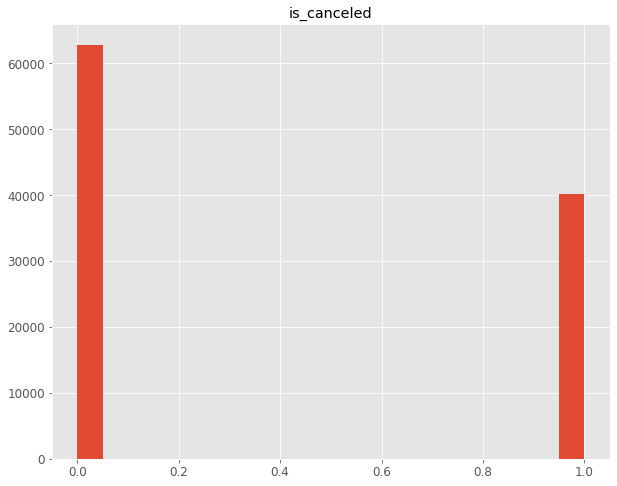

Coluna < lead_time > tem:	0 valores NA.


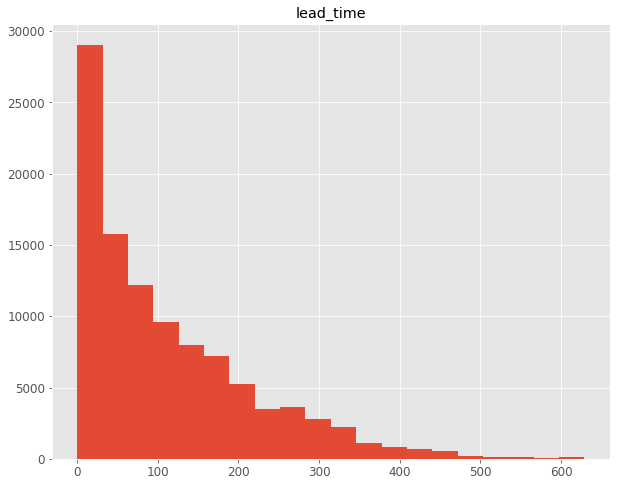

Coluna < arrival_date_year > tem:	0 valores NA.


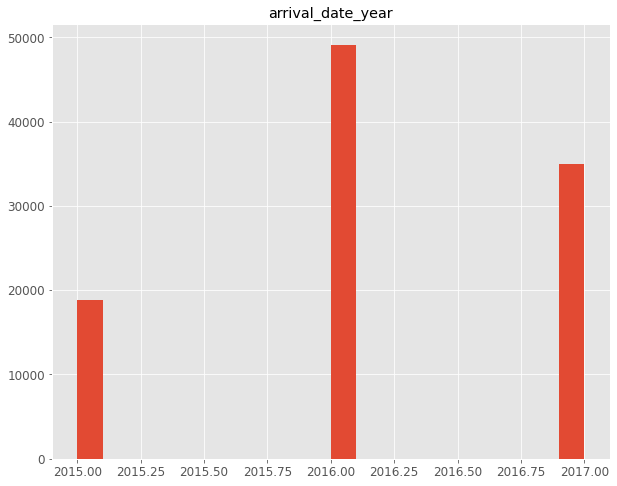

Coluna < arrival_date_week_number > tem:	0 valores NA.


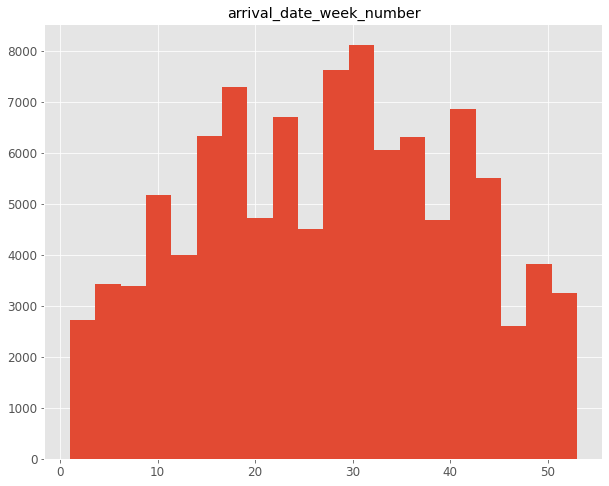

Coluna < arrival_date_day_of_month > tem:	0 valores NA.


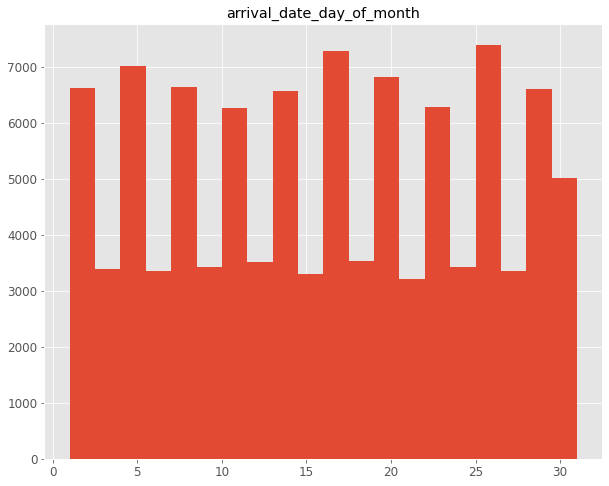

Coluna < stays_in_weekend_nights > tem:	0 valores NA.


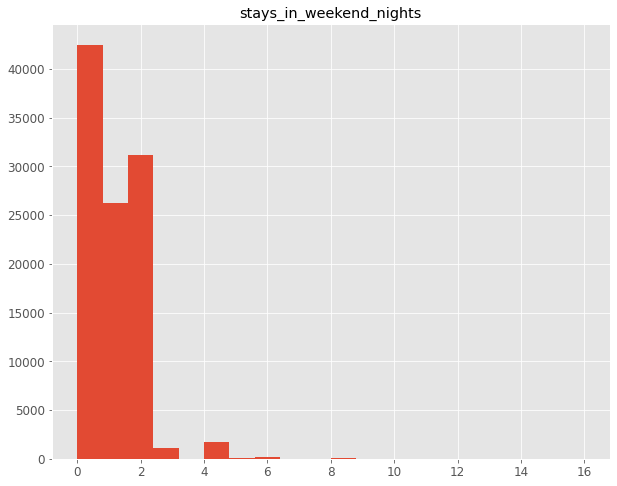

Coluna < stays_in_week_nights > tem:	0 valores NA.


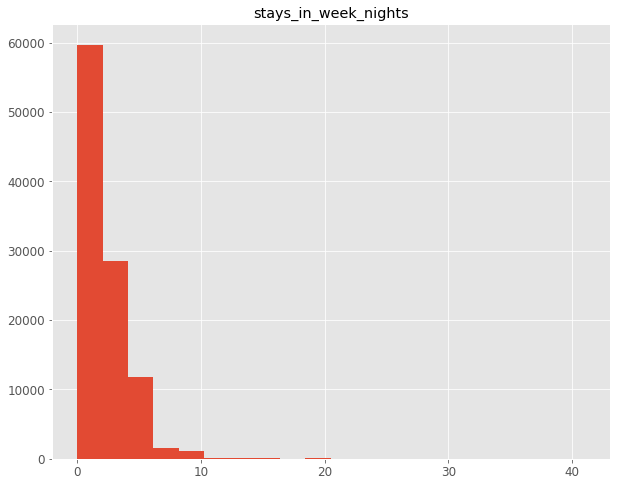

Coluna < adults > tem:	0 valores NA.


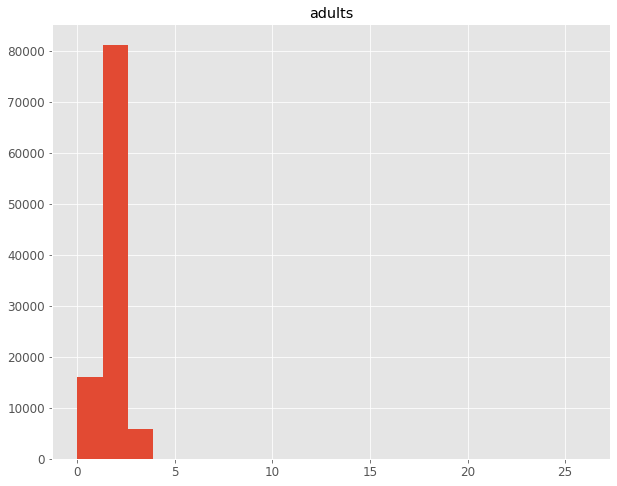

Coluna < children > tem:	0 valores NA.


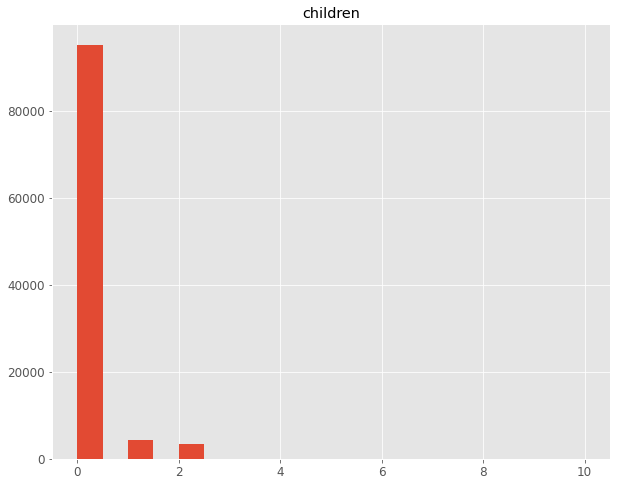

Coluna < babies > tem:	0 valores NA.


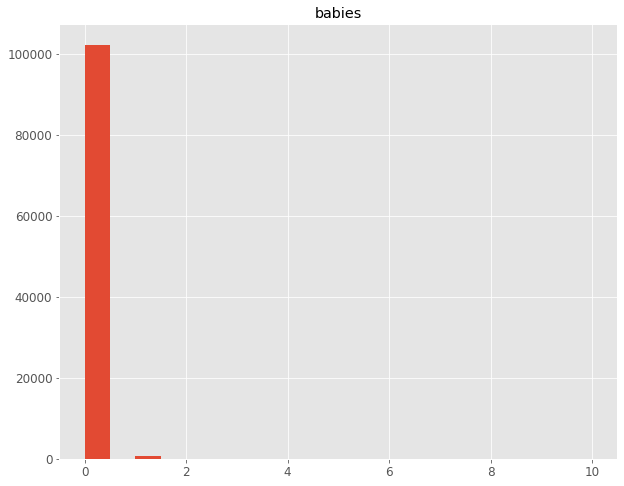

Coluna < is_repeated_guest > tem:	0 valores NA.


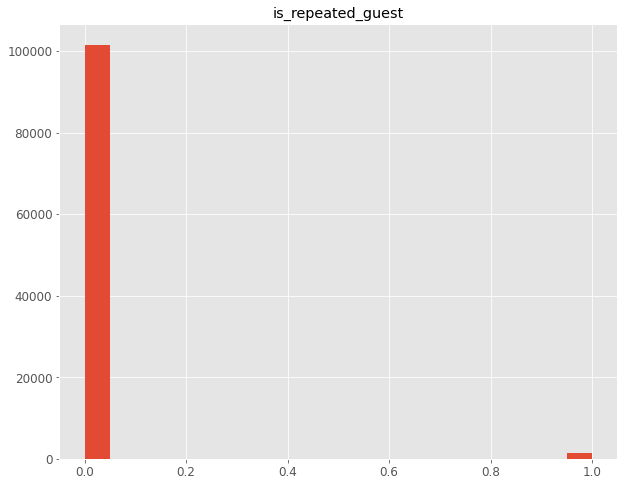

Coluna < previous_cancellations > tem:	0 valores NA.


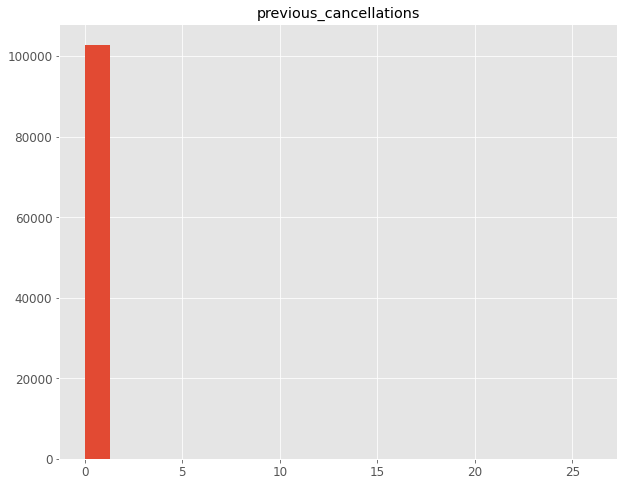

Coluna < previous_bookings_not_canceled > tem:	0 valores NA.


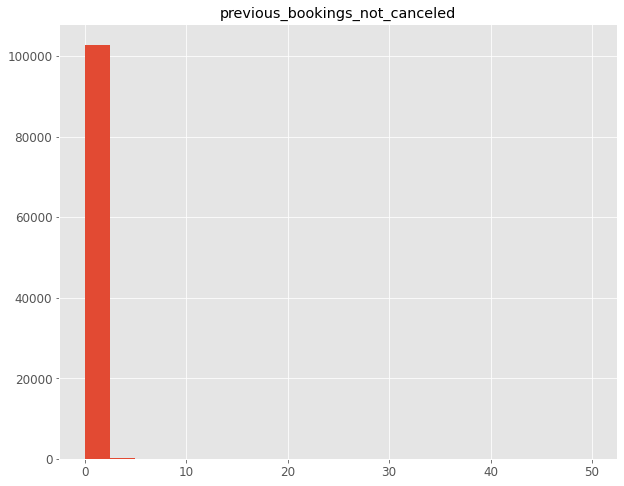

Coluna < booking_changes > tem:	0 valores NA.


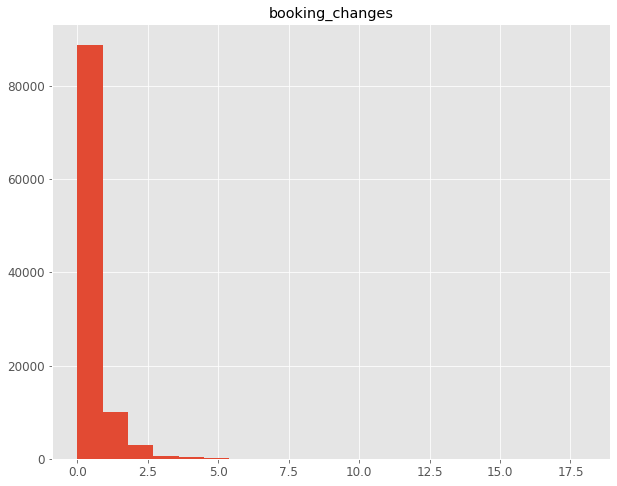

Coluna < agent > tem:	0 valores NA.


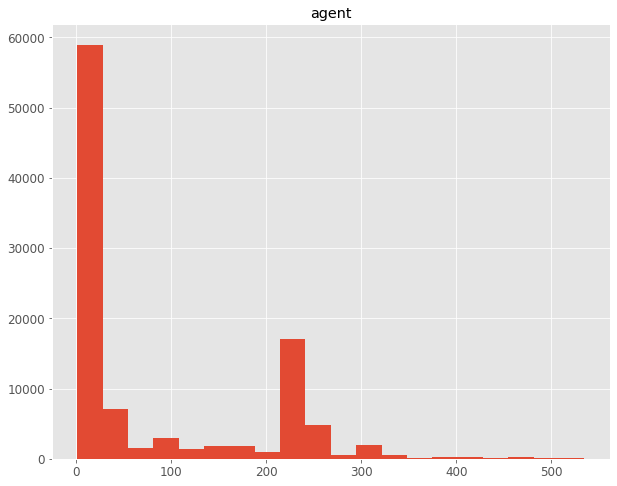

Coluna < days_in_waiting_list > tem:	0 valores NA.


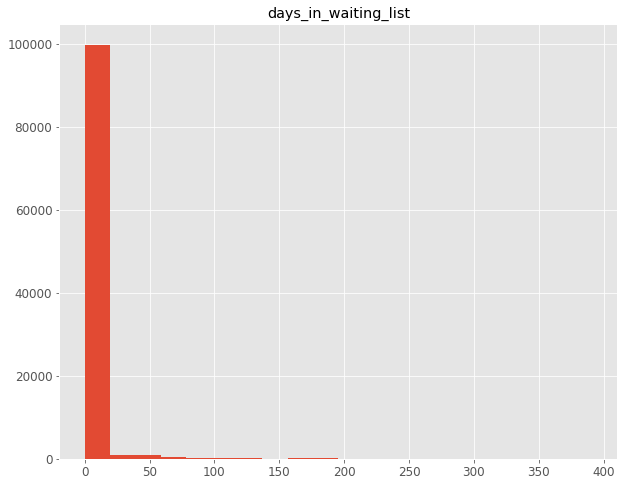

Coluna < adr > tem:	0 valores NA.


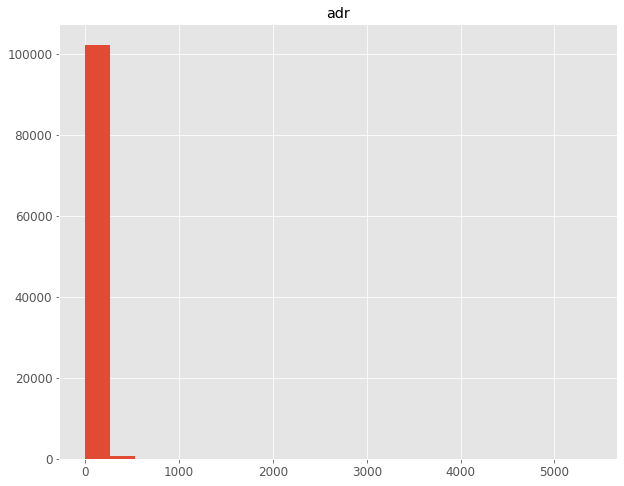

Coluna < required_car_parking_spaces > tem:	0 valores NA.


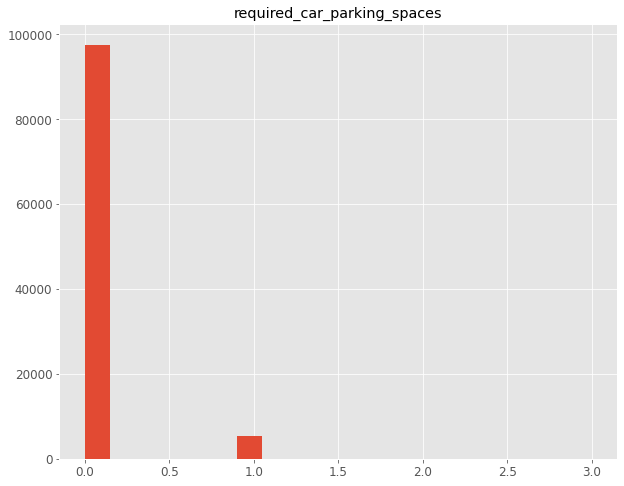

Coluna < total_of_special_requests > tem:	0 valores NA.


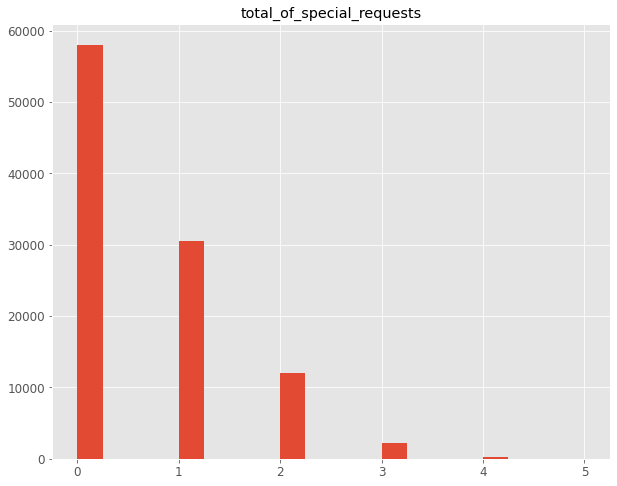

Coluna < arrival_date_month_numerical > tem:	0 valores NA.


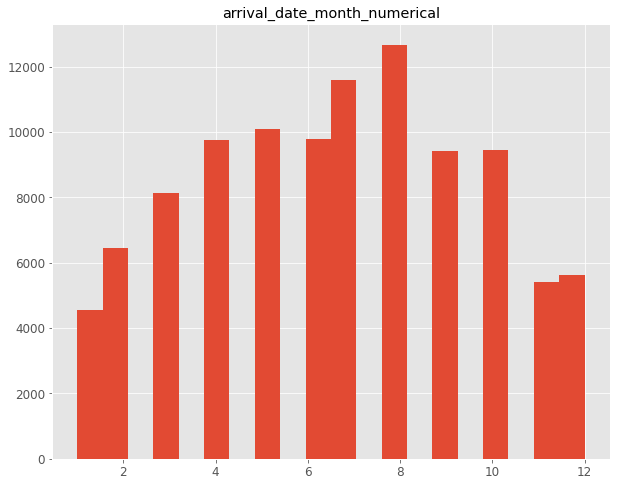

Coluna < reserved_room_type_numerical > tem:	0 valores NA.


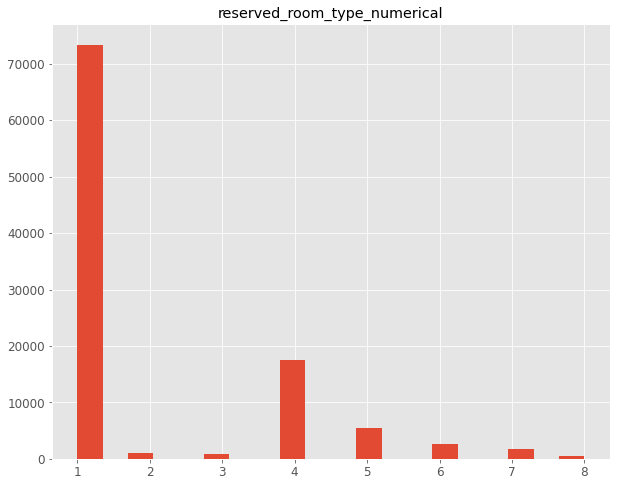

Coluna < assigned_room_type_numerical > tem:	0 valores NA.


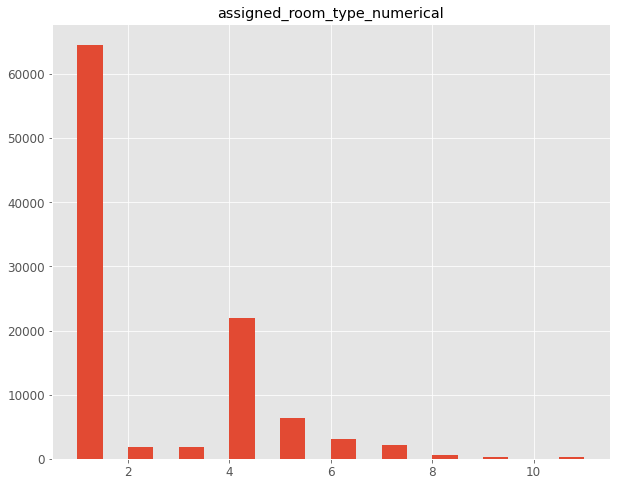

Coluna < deposit_type_numerical > tem:	0 valores NA.


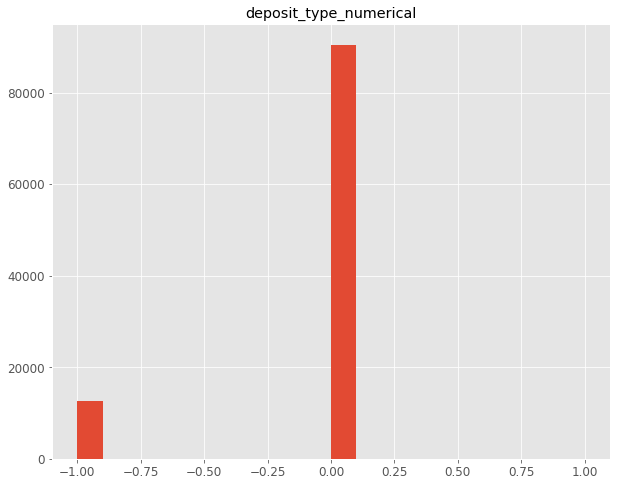

Coluna < customer_type_numerical > tem:	0 valores NA.


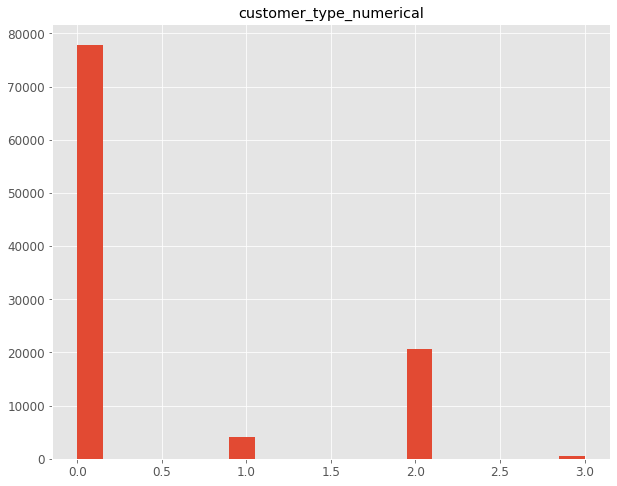

Coluna < hotel_numerical > tem:	0 valores NA.


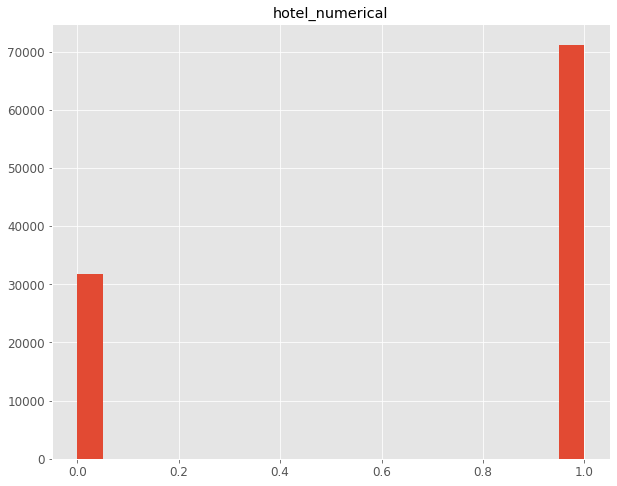

Coluna < meal_numerical > tem:	0 valores NA.


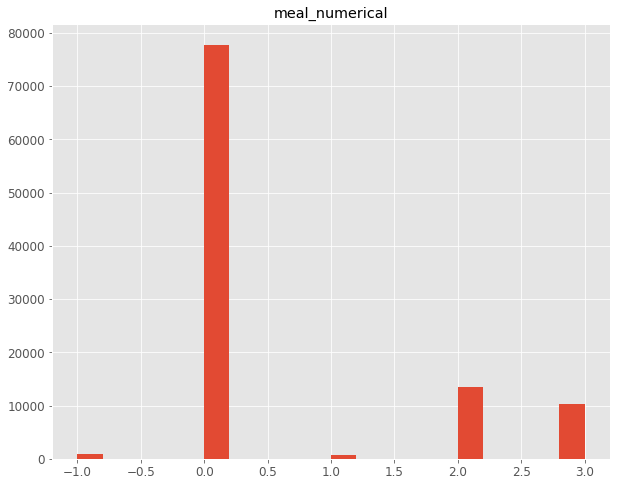

Coluna < market_segment_numerical > tem:	0 valores NA.


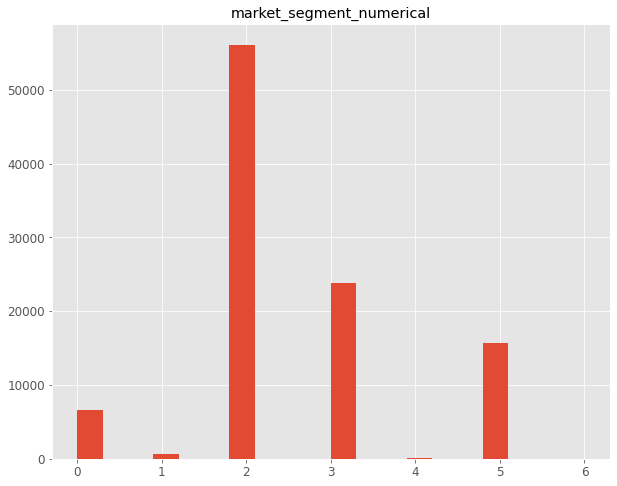

Coluna < distribution_channel_numerical > tem:	0 valores NA.


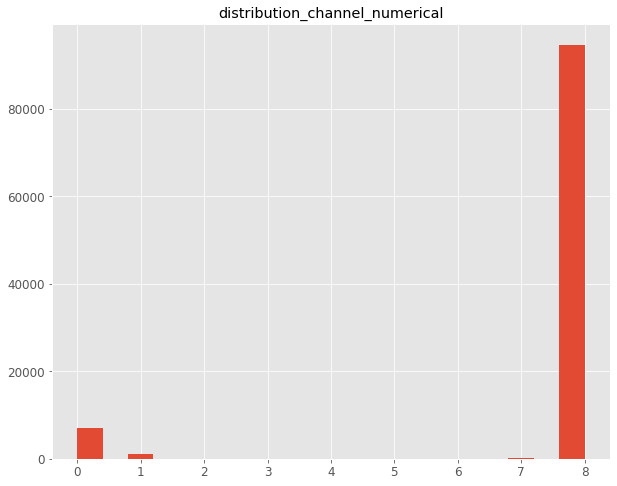

In [58]:
# Checa valores NA e cria alguns Plots
for column, series in dataset.items():
    print(f"Coluna < {column} > tem:\t{sum(series.isna())} valores NA.")
    plt.figure(figsize=[10,8])
    plt.hist(series, bins=20)
    plt.title(column)
    plt.show()

Tudo parece ok. Vamos verificar se temos algum prolema de colinearidade, ou seja, correlação muito alta ntre as variáveis. Se tiver teremos que tomar alguma ação, pois a correlação é um problema.

In [59]:
# Calcula a correlação
corr = dataset.corr()

<AxesSubplot:>

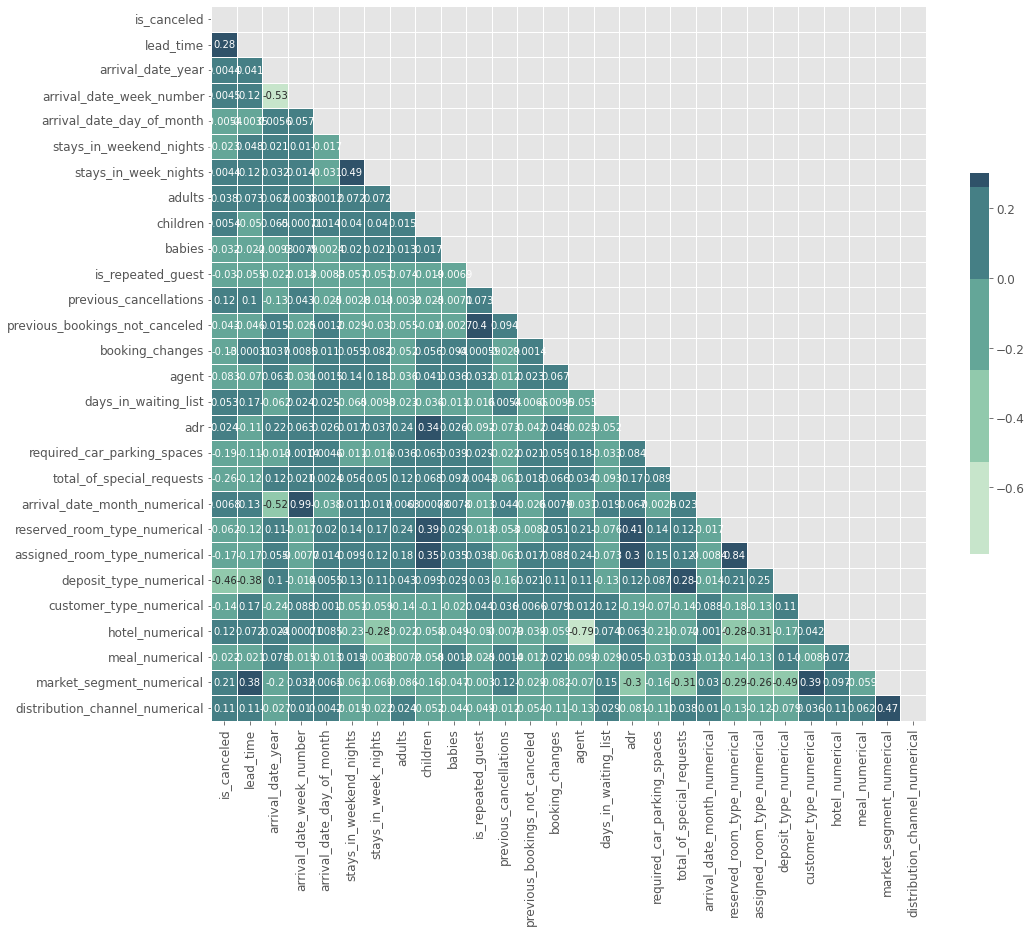

In [60]:
# Plot da Matriz de Correlação

# Máscara
mask = np.triu(np.ones_like(corr, dtype = np.bool))

# Área de plotagem
f, ax = plt.subplots(figsize = (16, 14))

# Paleta de cores
cmap = sns.cubehelix_palette(rot=-.4)

# Mapa de calor com a correlação (Matriz de Correlação)
sns.heatmap(corr, mask = mask, cmap = cmap, vmax = .3, center = 0, annot = True, square = True, 
            linewidths = .5, cbar_kws = {"shrink": .5})

Podemos avançar.

## Pré-Processamento dos Dados

Limpea concluída, podemos preparar os dados para treinamento.

Primeiro separamos o dataset em X e y.

In [61]:
# Preparamos os dados de entrada em x
X = dataset.drop(["is_canceled"], axis = 1)

In [62]:
# Preparamos a variável de saída y
y = dataset["is_canceled"]

In [63]:
# Convertemos para o tipo categórico
y = to_categorical(y, num_classes = None)

Dividimos os dados em treino e teste, com proporção 80/20.

In [64]:
# Divisão em treino e teste
X_treino, X_teste, y_treino, y_teste = train_test_split(X, y, shuffle = True, test_size = 0.2, random_state = 420)

In [65]:
# Shape
print("Shape de X_treino =", X_treino.shape)
print("Shape de y_treino =", y_treino.shape)
print("Shape de X_teste =", X_teste.shape)
print("Shape de y_teste =", y_teste.shape)

Shape de X_treino = (82438, 27)
Shape de y_treino = (82438, 2)
Shape de X_teste = (20610, 27)
Shape de y_teste = (20610, 2)


Como as variáveis estão em escala diferente, vamos padronizar e deixar tudo na mesma escala. Fazemos isso somente com X.

In [66]:
# Criamos o objeto scaler
scaler = MinMaxScaler()

In [67]:
# Treinamos e Aplicamos o scaler aos dados de entrada de treino
X_treino = scaler.fit_transform(X_treino)

In [68]:
# Aplicamos o scaler aos dados de entrada de teste
X_teste = scaler.transform(X_teste)

In [69]:
# Resumo
print(f'Matriz da Variável de Entrada:\t{X.shape}\nMatriz da Variável de Saída:\t{y.shape}')

Matriz da Variável de Entrada:	(103048, 27)
Matriz da Variável de Saída:	(103048, 2)


## Construção do Modelo

Vamos criar o modelo de Deep Learning com 5 camadas densas, camadas de dropout para evitar o overfitting e ativação softmax para a classificação.

In [70]:
# Criamos o modelo
modelo = Sequential()
modelo.add(Dense(200, input_dim = X.shape[1], activation = 'relu'))
modelo.add(Dropout(0.1))
modelo.add(Dense(200, activation = 'relu'))
modelo.add(Dropout(0.2))    
modelo.add(Dense(200, activation = 'relu'))
modelo.add(Dropout(0.2))
modelo.add(Dense(100, activation = 'relu'))
modelo.add(Dropout(0.1))
modelo.add(Dense(2, activation = 'softmax'))

In [73]:
# Usaremos como otimizador o algoritmo Nadam pois o conjunto de dados é complexo
# https://keras.io/api/optimizers/Nadam/
otimizador = tf.keras.optimizers.Nadam(learning_rate = 0.0001, 
                   beta_1 = 0.9, 
                   beta_2 = 0.999, 
                   epsilon = 1e-07)

In [74]:
# Compilamos o modelo
modelo.compile(optimizer = otimizador, loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [75]:
# Vamos criar 2 callbacks
# Um para finalizar o treinamento se depois de 20 passadas o erro não mudar
# Outro para reduzir a taxa de aprendizagem se o erro não mudar após 5 passadas
callbacks = [EarlyStopping(monitor = "loss", patience = 20), 
             ReduceLROnPlateau(monitor = "loss", patience = 5)]

In [76]:
# Hiperparâmetros
num_epochs = 65
batch_size = 32

In [77]:
# Treinamento

print("\nTreinamento Iniciado.\n")

history = modelo.fit(X_treino, 
                     y_treino, 
                     epochs = num_epochs, 
                     batch_size = batch_size, 
                     callbacks = callbacks)

print("\nTreinamento Concluído.\n")


Treinamento Iniciado.

Epoch 1/65
2577/2577 [==============================] - 23s 8ms/step - loss: 0.5000 - accuracy: 0.7490
Epoch 2/65
2577/2577 [==============================] - 21s 8ms/step - loss: 0.4475 - accuracy: 0.7785
Epoch 3/65
2577/2577 [==============================] - 22s 8ms/step - loss: 0.4339 - accuracy: 0.7859
Epoch 4/65
2577/2577 [==============================] - 21s 8ms/step - loss: 0.4226 - accuracy: 0.7937
Epoch 5/65
2577/2577 [==============================] - 21s 8ms/step - loss: 0.4137 - accuracy: 0.7984
Epoch 6/65
2577/2577 [==============================] - 21s 8ms/step - loss: 0.4080 - accuracy: 0.8030
Epoch 7/65
2577/2577 [==============================] - 21s 8ms/step - loss: 0.4030 - accuracy: 0.8069
Epoch 8/65
2577/2577 [==============================] - 21s 8ms/step - loss: 0.3979 - accuracy: 0.8111
Epoch 9/65
2577/2577 [==============================] - 21s 8ms/step - loss: 0.3941 - accuracy: 0.8114
Epoch 10/65
2577/2577 [==========================

## Avaliação do Modelo

O treinamento ocorreu com sucesso. Vamos agora avaliar o modelo.

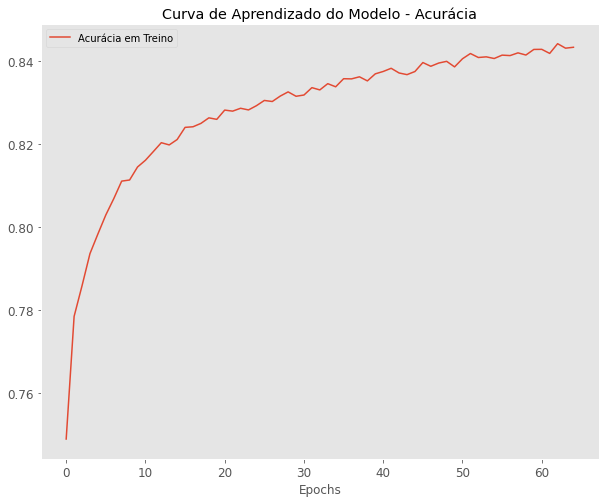

In [78]:
# Plot da Acurácia em Treino
plt.figure(figsize = [10,8])
plt.title("Curva de Aprendizado do Modelo - Acurácia")
plt.plot(history.history['accuracy'], label = 'Acurácia em Treino')
plt.xlabel("Epochs")
plt.legend()
plt.grid()

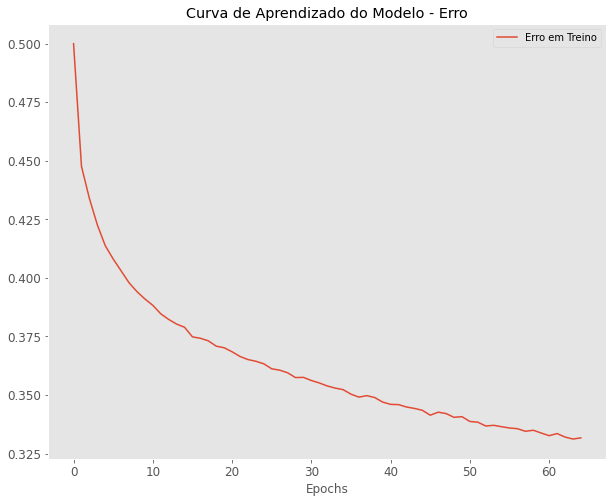

In [79]:
# Plot do Erro em Treino
plt.figure(figsize = [10,8])
plt.title("Curva de Aprendizado do Modelo - Erro")
plt.plot(history.history['loss'], label = 'Erro em Treino')
plt.xlabel("Epochs")
plt.legend()
plt.grid()

In [80]:
# Fazemos as previsões com os dados de teste
previsoes = modelo.predict(X_teste)

In [81]:
# Convertemos as previsões em previsões de classe
y_pred = (previsoes > 0.5) 

In [82]:
# Calculamos a acurácia comparando valor real com valor previsto
accuracy_score(y_teste, y_pred)

0.8377971858321204

Nosso modelo tem uma performance de 84%. Um bom trabalho. Mas talvez alguns ajustes possam ser feitos no modelo para melhorar essa performance. Deixaremos isso com você.

In [ ]:
# Salva o modelo
modelo.save("modelo/modelo.h5")